# XGBoostによる分類モデルのテスト
最適なパラメータを探す
## データ準備

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import xgboost as xgb
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics._scorer import _SCORERS
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [107]:
df = pd.read_csv("./fake_job_postings.csv")
df = df.drop("job_id", axis=1) # job_id = 0,1,2,... 学習価値なし
# df.fillna('null', inplace=True) # 空の文字列 -> null (XGBoost APIでは無くてもいける？)

# 偽文書と本物文書
Fakedf = df[ df['fraudulent'] == 1 ]
Realdf = df[ df['fraudulent'] == 0 ]

# 問題文データのランダム抽出 (偽文書割合50%)
detaset_Fake, quiz_Fake = train_test_split(Fakedf, test_size=50)
detaset_Real, quiz_Real = train_test_split(Realdf, test_size=50)

# 問題文データのランダムシャッフル
quizdf = pd.concat([quiz_Real, quiz_Fake])
shuffled_df = quizdf.sample(frac=1).reset_index(drop=True)
quiz = shuffled_df.drop("fraudulent", axis=1)        # 問題文
quiz_solution = shuffled_df["fraudulent"].to_numpy() # 解答

# 訓練データとテストデータへの分割 (テストデータ25%)
train_Fake, test_Fake = train_test_split(detaset_Fake)
train_Real, test_Real = train_test_split(detaset_Real)
traindf = pd.concat([train_Real, train_Fake])
testdf = pd.concat([test_Real, test_Fake])
traindf = traindf.sample(frac=1).reset_index(drop=True)
testdf = testdf.sample(frac=1).reset_index(drop=True)
train_X = testdf.drop('fraudulent', axis=1)
train_y = testdf['fraudulent']
test_X = testdf.drop('fraudulent', axis=1)
test_y = testdf['fraudulent']

データの傾向を確認する。

In [108]:
print(train_X.head())

                                               title               location  \
0  Coventry Customer Service Apprenticeship under...         GB, , Coventry   
1                            English Teacher Abroad   US, MA, Chestnut Hill   
2               PURPOSE: Project & Business Managers                    NaN   
3                    Customer Service Representative   US, PA, Philadelphia   
4  Technology Manager - PVC Manufacturing MS Offi...    US, OH, USA Midwest   

         department salary_range  \
0               NaN          NaN   
1               NaN          NaN   
2               NaN          NaN   
3  customer service  30000-40000   
4               NaN          NaN   

                                     company_profile  \
0  Established on the principles that full time e...   
1  We help teachers get safe &amp; secure jobs ab...   
2  We are not your average Monday mail recruiters...   
3                                                NaN   
4  We Provide Full Time Perm

カテゴリカルデータの値と頻度を確認

In [109]:
category_columns = ['location','department','salary_range','employment_type','required_experience','required_education','industry','function']
for cc in category_columns:
    print(f"---{cc}---")
    pprint(train_X[cc].value_counts())

---location---
location
GB, LND, London                    185
US, NY, New York                   154
US, CA, San Francisco              137
GR, I, Athens                      115
US, ,                               88
                                  ... 
TT, CTT, City                        1
US, NJ, Franklin Lakes               1
US, OR, NW Portland & Hillsboro      1
US, TX, Grapevine                    1
GB, ENG, Nr. West Drayton            1
Name: count, Length: 1383, dtype: int64
---department---
department
Sales                             141
Engineering                       129
Marketing                         103
Operations                         75
IT                                 59
                                 ... 
Research & Development              1
Freelancer                          1
marketing                           1
Sales and Business Development      1
Embedded Applications               1
Name: count, Length: 553, dtype: int64
---salary_range---
sal

カテゴリカルデータをすべてOne-hot encodeするのは現実的ではない。

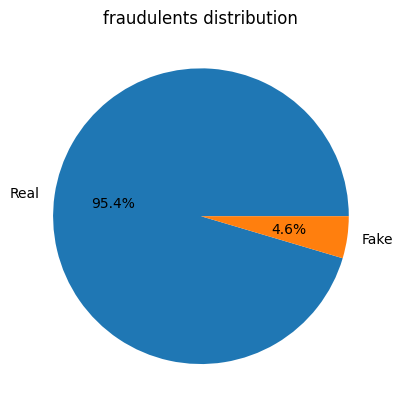

In [110]:
train_y.value_counts().rename(index={0: 'Real', 1: 'Fake'}).plot(kind='pie', autopct='%1.1f%%')
plt.title('fraudulents distribution')
plt.ylabel('')  # y軸ラベルを非表示にする
plt.show()

偽文書と本物文書の割合が不均衡のため、精度だけでモデル性能を評価するのは適切ではない。
不均衡なデータセットでは、多数派クラス（この場合はReal）を予測するだけで高い精度を達成できるため、モデルの真の性能を正確に反映しないことがある。

よって評価にはF1 score（適合率と再現率の調和平均）を用いる。
- 適合率（Precision）
  - 適合率はFakeと予測されたインスタンスのうち、実際にFakeである割合。
  - 積極的にRealと予測するとPrecisionが高くなる
- 再現率（Recall）
  - 再現率は、実際にFakeであるインスタンスのうち、正しくFakeと予測された割合です。
  - 積極的にFakeと予測するとRecallが高くなる
- 両者はトレードオフ関係にあり、バランスが大事

In [111]:
# 利用可能な評価指標
pprint(sorted(_SCORERS.keys()))

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

### 訓練データの加工
前処理を行って、データを扱いやすくする。

#### カテゴリカルデータのエンコード

In [112]:
encoded_train_X = pd.get_dummies(train_X, columns=['employment_type'])
encoded_test_X = pd.get_dummies(test_X, columns=['employment_type'])
print(encoded_train_X.columns)

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'required_experience',
       'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary'],
      dtype='object')


required_experienceとrequired_educationをレベル別に数値化する。

In [113]:
def int_convert(value):
    try:
        output = int(value)
        return output
    except ValueError:
        return np.nan
    
# required_experience
def encoder_experience(text):
    experience_levels = {
        "Not Applicable": 0,
        "Internship": 1,
        "Entry level": 2,
        "Associate": 3,
        "Mid-Senior level": 4,
        "Director": 5,
        "Executive": 6
    }
    return int_convert(experience_levels.get(text, np.nan))

# required_education
def encoder_education(text):
    education_levels = {
        "Unspecified": 0,
        "Some High School Coursework": 1,
        "High School or equivalent": 2,
        "Vocational - HS Diploma": 2,
        "Some College Coursework Completed": 3,
        "Associate Degree": 4,
        "Vocational - Degree": 5,
        "Certification": 5,
        "Bachelor's Degree": 5,
        "Professional": 6,
        "Master's Degree": 7,
        "Doctorate": 8
    }
    return int_convert(education_levels.get(text, np.nan))

In [114]:
# 二度以上実行するとすべて0になってしまうので注意
encoded_train_X['required_experience'] = encoded_train_X['required_experience'].apply(encoder_experience)
encoded_test_X['required_experience'] = encoded_test_X['required_experience'].apply(encoder_experience)
encoded_train_X['required_education'] = encoded_train_X['required_education'].apply(encoder_education)
encoded_test_X['required_education'] = encoded_test_X['required_education'].apply(encoder_education)

In [115]:
pprint(encoded_train_X['required_experience'].value_counts())
pprint(encoded_train_X['required_education'].value_counts())

required_experience
4.0    961
2.0    653
3.0    565
0.0    290
1.0    106
5.0    100
6.0     36
Name: count, dtype: int64
required_education
5.0    1294
2.0     539
0.0     365
7.0     104
4.0      72
3.0      25
6.0      18
8.0       5
1.0       3
Name: count, dtype: int64


salary_rangeを上限値と下限値でカラムを分ける。

In [116]:
encoded_train_X['salary_lower'] = encoded_train_X['salary_range'].str.split('-').str[0].apply(int_convert)
encoded_train_X['salary_upper'] = encoded_train_X['salary_range'].str.split('-').str[1].apply(int_convert)
encoded_train_X = encoded_train_X.drop('salary_range', axis=1)
# encoded_train_X['salary_lower'].fillna('null', inplace=True)
# encoded_train_X['salary_upper'].fillna('null', inplace=True)

encoded_test_X['salary_lower'] = encoded_test_X['salary_range'].str.split('-').str[0].apply(int_convert)
encoded_test_X['salary_upper'] = encoded_test_X['salary_range'].str.split('-').str[1].apply(int_convert)
encoded_test_X = encoded_test_X.drop('salary_range', axis=1)
# encoded_test_X['salary_lower'].fillna('null', inplace=True)
# encoded_test_X['salary_upper'].fillna('null', inplace=True)

In [117]:
pprint(encoded_train_X['salary_lower'].value_counts())
pprint(encoded_train_X['salary_upper'].value_counts())

salary_lower
0.0         50
40000.0     41
45000.0     40
30000.0     39
50000.0     30
            ..
9.0          1
550000.0     1
19500.0      1
15600.0      1
18720.0      1
Name: count, Length: 123, dtype: int64
salary_upper
100000.0    38
0.0         38
50000.0     36
80000.0     28
30000.0     27
            ..
117000.0     1
84000.0      1
30.0         1
68000.0      1
21840.0      1
Name: count, Length: 151, dtype: int64


#### Embedding
TF-IDF Vectorizer（[解説](https://www.analyticsvidhya.com/blog/2021/06/part-5-step-by-step-guide-to-master-nlp-text-vectorization-approaches/)）を用いて、意味ある単語を重点的にベクトル化

In [118]:
encoded_train_X.columns

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'telecommuting', 'has_company_logo',
       'has_questions', 'required_experience', 'required_education',
       'industry', 'function', 'employment_type_Contract',
       'employment_type_Full-time', 'employment_type_Other',
       'employment_type_Part-time', 'employment_type_Temporary',
       'salary_lower', 'salary_upper'],
      dtype='object')

In [119]:
text_columns = ['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'industry', 'function']
vectorized_train_X = encoded_train_X
vectorized_test_X = encoded_test_X

# ベクトル化
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(encoded_train_X[text_columns])
vectors_test = vectorizer.fit_transform(encoded_test_X[text_columns])

# スパース行列を密な形式に変換
vectorized_train_X[text_columns] = pd.DataFrame(vectors_train.toarray(), columns=vectorizer.get_feature_names_out(), dtype="float")
vectorized_test_X[text_columns] = pd.DataFrame(vectors_test.toarray(), columns=vectorizer.get_feature_names_out(), dtype="float")

print(vectorized_train_X.head())

   title  location  department  company_profile  description  requirements  \
0    0.0       0.0         0.0              0.0          0.0           0.0   
1    0.0       0.0         0.0              0.0          0.0           0.0   
2    0.0       0.0         1.0              0.0          0.0           0.0   
3    0.0       1.0         0.0              0.0          0.0           0.0   
4    0.0       0.0         0.0              1.0          0.0           0.0   

   benefits  telecommuting  has_company_logo  has_questions  ...  \
0       0.0              0                 1              1  ...   
1       1.0              0                 1              1  ...   
2       0.0              0                 1              0  ...   
3       0.0              1                 1              0  ...   
4       0.0              0                 0              0  ...   

   required_education  industry  function  employment_type_Contract  \
0                 2.0       0.0       1.0          

## モデル構築1 (文章加工なし)

GridSearchCVではDMatrixを扱えないので、自分で実装する

In [120]:
model = xgb.XGBClassifier(random_state=0) # fix seed
dtrain = xgb.DMatrix(data=vectorized_train_X, label=train_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能

parameters = {
    "n_estimators" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
}
model_opt = GridSearchCV(model, parameters, scoring="f1")
model_opt.fit(dtrain)
print(model_opt.best_params_)

TypeError: Singleton array array(<xgboost.core.DMatrix object at 0x0000020E60320130>, dtype=object) cannot be considered a valid collection.

In [ ]:
dtrain = xgb.DMatrix(data=vectorized_train_X, label=train_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能
dtest = xgb.DMatrix(data=vectorized_test_X, label=test_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能

parameters = {
    "n_estimators" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
}
num_round = 10

best_score = 0
best_params = None

# パラメータのすべての組み合わせに対してループ
for params in product(*parameters.values()):
    param_dict = dict(zip(parameters.keys(), params))
    param_dict['objective'] = 'binary:hinge' # This makes 0 or 1, rather than producing probabilities.
    
    # モデルの訓練と評価
    trained_model = xgb.train(param_dict, dtrain, num_round)
    prediceted_y = trained_model.predict(dtest)
    score = f1_score(test_y, prediceted_y)

    # ベストスコアの更新
    if score > best_score:
        best_score = score
        best_params = param_dict

print("Best Score:", best_score)
print("Best Parameters:", best_params)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:title: object, location: object, department: object, salary_range: object, company_profile: object, description: object, requirements: object, benefits: object, employment_type: object, required_experience: object, required_education: object, industry: object, function: object